### Simple Machine Learning Clustering of Devices 

#### Imports

In [170]:
import os
import json
import pandas as pd
import numpy as np

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance


from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import VarianceThreshold



import matplotlib.pyplot as plt
import seaborn as sns

from imagehat.identifiers.eixf_attribute_information import EXIF_TAG_DICT_REV, GPS_TAG_DICT_REV, INTEROP_TAG_DICT_REV

### Inspecting Dresden


In [171]:
dresden_folder = os.path.join("datasets", "json_datasets", "dresden_images", "dresden_metadata.json") 

with open(dresden_folder, "r") as f:
    json_dataset = json.load(f)

json_dataset = {k.split("\\")[-1]: v for k, v in json_dataset.items()}


In [172]:
# LAST two parts removed (_0_48387.JPG)
device_names = []

for file_name in json_dataset.keys():

    file_name = file_name.replace('.JPG', '').replace('.jpg', '')
    
    parts = file_name.split('_')
    
    device_name = '_'.join(parts[:-2])
    
    device_names.append(device_name)

unique_devices = set(device_names)
device_count = len(unique_devices)

print("Extracted Device Names:", sorted(unique_devices))
print("Number of Unique Devices:", device_count)
print("Number of Unique Images:", len(json_dataset.keys()))


Extracted Device Names: ['Agfa_DC-504', 'Agfa_DC-733s', 'Agfa_DC-830i', 'Agfa_Sensor505-x', 'Agfa_Sensor530s', 'Canon_Ixus55', 'Canon_Ixus70', 'Canon_PowerShotA640', 'Casio_EX-Z150', 'FujiFilm_FinePixJ50', 'Kodak_M1063', 'Nikon_CoolPixS710', 'Nikon_D200', 'Nikon_D70', 'Nikon_D70s', 'Olympus_mju_1050SW', 'Panasonic_DMC-FZ50', 'Pentax_OptioA40', 'Pentax_OptioW60', 'Praktica_DCZ5.9', 'Ricoh_GX100', 'Rollei_RCP-7325XS', 'Samsung_L74wide', 'Samsung_NV15', 'Sony_DSC-H50', 'Sony_DSC-T77', 'Sony_DSC-W170']
Number of Unique Devices: 27
Number of Unique Images: 16961


In [173]:
list_images = json_dataset.keys()
images_per_device = {}

def remove_extension(filename):
    no_ext = os.path.splitext(filename)[0]
    return no_ext.rsplit('_', 1)[0]           


device_feature = list(map(remove_extension, list_images))
unique_devices = set(device_feature)
print("Unique Devices:", len(unique_devices))
print("Unique Devices:", sorted(unique_devices))


Unique Devices: 74
Unique Devices: ['Agfa_DC-504_0', 'Agfa_DC-733s_0', 'Agfa_DC-830i_0', 'Agfa_Sensor505-x_0', 'Agfa_Sensor530s_0', 'Canon_Ixus55_0', 'Canon_Ixus70_0', 'Canon_Ixus70_1', 'Canon_Ixus70_2', 'Canon_PowerShotA640_0', 'Casio_EX-Z150_0', 'Casio_EX-Z150_1', 'Casio_EX-Z150_2', 'Casio_EX-Z150_3', 'Casio_EX-Z150_4', 'FujiFilm_FinePixJ50_0', 'FujiFilm_FinePixJ50_1', 'FujiFilm_FinePixJ50_2', 'Kodak_M1063_0', 'Kodak_M1063_1', 'Kodak_M1063_2', 'Kodak_M1063_3', 'Kodak_M1063_4', 'Nikon_CoolPixS710_0', 'Nikon_CoolPixS710_1', 'Nikon_CoolPixS710_2', 'Nikon_CoolPixS710_3', 'Nikon_CoolPixS710_4', 'Nikon_D200_0', 'Nikon_D200_1', 'Nikon_D70_0', 'Nikon_D70_1', 'Nikon_D70s_0', 'Nikon_D70s_1', 'Olympus_mju_1050SW_0', 'Olympus_mju_1050SW_1', 'Olympus_mju_1050SW_2', 'Olympus_mju_1050SW_3', 'Olympus_mju_1050SW_4', 'Panasonic_DMC-FZ50_0', 'Panasonic_DMC-FZ50_1', 'Panasonic_DMC-FZ50_2', 'Pentax_OptioA40_0', 'Pentax_OptioA40_1', 'Pentax_OptioA40_2', 'Pentax_OptioA40_3', 'Pentax_OptioW60_0', 'Praktica_

['Nikon', 'Sony', 'Canon', 'Samsung', 'Agfa', 'Kodak', 'FujiFilm', 'Nikon', 'Casio', 'Pentax', 'Sony', 'Sony', 'Casio', 'Nikon', 'Nikon', 'Nikon', 'Nikon', 'Kodak', 'Ricoh', 'Olympus', 'Pentax', 'Agfa', 'Rollei', 'Samsung', 'Canon', 'Casio', 'Kodak', 'Ricoh', 'Casio', 'Sony', 'FujiFilm', 'Sony', 'Samsung', 'Praktica', 'Sony', 'Panasonic', 'Canon', 'Panasonic', 'Samsung', 'Nikon', 'Ricoh', 'FujiFilm', 'Canon', 'Ricoh', 'Pentax', 'Agfa', 'Kodak', 'Praktica', 'Praktica', 'Agfa', 'Sony', 'Panasonic', 'Kodak', 'Praktica', 'Casio', 'Nikon', 'Samsung', 'Sony', 'Praktica', 'Canon', 'Pentax', 'Olympus', 'Olympus', 'Rollei', 'Nikon', 'Olympus', 'Nikon', 'Samsung', 'Olympus', 'Pentax', 'Nikon', 'Ricoh', 'Agfa', 'Rollei']


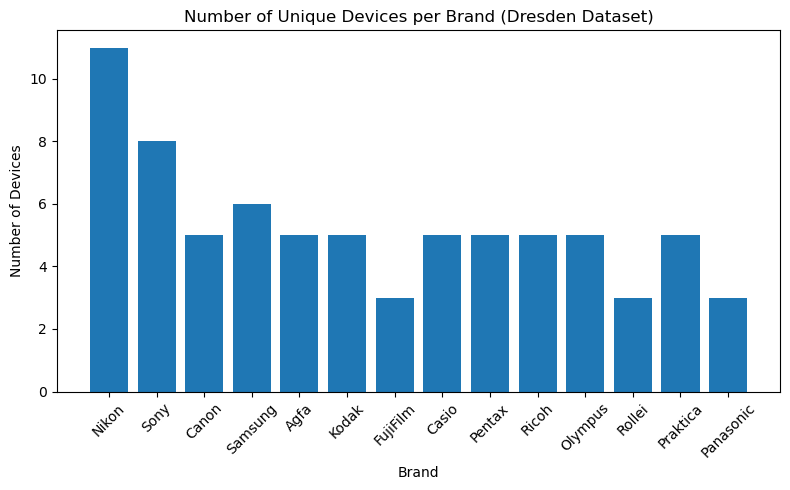

In [174]:
brands = [model.split('_')[0] for model in unique_devices
          ]
print(brands)

brand_counts = Counter(brands)

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(brand_counts.keys(), brand_counts.values())
plt.xticks(rotation=45)
plt.xlabel("Brand")
plt.ylabel("Number of Devices")
plt.title("Number of Unique Devices per Brand (Dresden Dataset)")
plt.tight_layout()
plt.show()

### Inspecting DivNoise

### Preprocessing Data

In [175]:
def get_baseline_tags(tag_dict) -> list:
    sorted_keys = sorted(tag_dict.keys(), key=lambda x: int.from_bytes(x, 'big'))
    tag_names = [tag_dict[k] for k in sorted_keys]
    dec_values = [int.from_bytes(k, 'big') for k in sorted_keys]
    return dec_values, tag_names

In [176]:
exif_values, exif_baseline = get_baseline_tags(EXIF_TAG_DICT_REV)
gps_values, gps_baseline = get_baseline_tags(GPS_TAG_DICT_REV)
interop_values, interop_baseline = get_baseline_tags(INTEROP_TAG_DICT_REV)


In [177]:
print("EXIF Baseline:", exif_baseline)
print("GPS Baseline:", gps_baseline) 
print("Interop Baseline:", interop_baseline)

EXIF Baseline: ['ExposureTime', 'FNumber', 'ExposureProgram', 'SpectralSensitivity', 'PhotographicSensitivity', 'OECF', 'SensitivityType', 'StandardOutputSensitivity', 'RecommendedExposureIndex', 'ISOSpeed', 'ISOSpeedLatitudeyyy', 'ISOSpeedLatitudezzz', 'ExifVersion', 'DateTimeOriginal', 'DateTimeDigitized', 'OffsetTime', 'OffsetTimeOriginal', 'OffsetTimeDigitized', 'ComponentsConfiguration', 'CompressedBitsPerPixel', 'ShutterSpeedValue', 'ApertureValue', 'BrightnessValue', 'ExposureBiasValue', 'MaxApertureValue', 'SubjectDistance', 'MeteringMode', 'LightSource', 'Flash', 'FocalLength', 'SubjectArea', 'MakerNote', 'UserComment', 'SubSecTime', 'SubSecTimeOriginal', 'SubSecTimeDigitized', 'Temperature', 'Humidity', 'Pressure', 'WaterDepth', 'Acceleration', 'CameraElevationAngle', 'FlashpixVersion', 'ColorSpace', 'PixelXDimension', 'PixelYDimension', 'RelatedSoundFile', 'InteroperabilityIFDPointer', 'FlashEnergy', 'SpatialFrequencyResponse', 'FocalPlaneXResolution', 'FocalPlaneYResolution

In [178]:
print("Verify Ascending Order:")
print("EXIF baseline:", exif_baseline)
print("EXIF values:", exif_values)
print("GPS values:", gps_values)
print("Interop values:", interop_values)

Verify Ascending Order:
EXIF baseline: ['ExposureTime', 'FNumber', 'ExposureProgram', 'SpectralSensitivity', 'PhotographicSensitivity', 'OECF', 'SensitivityType', 'StandardOutputSensitivity', 'RecommendedExposureIndex', 'ISOSpeed', 'ISOSpeedLatitudeyyy', 'ISOSpeedLatitudezzz', 'ExifVersion', 'DateTimeOriginal', 'DateTimeDigitized', 'OffsetTime', 'OffsetTimeOriginal', 'OffsetTimeDigitized', 'ComponentsConfiguration', 'CompressedBitsPerPixel', 'ShutterSpeedValue', 'ApertureValue', 'BrightnessValue', 'ExposureBiasValue', 'MaxApertureValue', 'SubjectDistance', 'MeteringMode', 'LightSource', 'Flash', 'FocalLength', 'SubjectArea', 'MakerNote', 'UserComment', 'SubSecTime', 'SubSecTimeOriginal', 'SubSecTimeDigitized', 'Temperature', 'Humidity', 'Pressure', 'WaterDepth', 'Acceleration', 'CameraElevationAngle', 'FlashpixVersion', 'ColorSpace', 'PixelXDimension', 'PixelYDimension', 'RelatedSoundFile', 'InteroperabilityIFDPointer', 'FlashEnergy', 'SpatialFrequencyResponse', 'FocalPlaneXResolution'

In [179]:
print("Control Sizes for feature extraction:")
print("EXIF sizes", len(exif_values))
print("GPS sizes", len(gps_values))
print("Interop sizes", len(interop_values))
print("Feature sizes", len(exif_values)+len(gps_values)+len(interop_values))


Control Sizes for feature extraction:
EXIF sizes 89
GPS sizes 32
Interop sizes 5
Feature sizes 126


#### Creating a DataFrame

In [180]:
# Creating a reference table

reference_df = pd.DataFrame({
    "id": range(1, len(list_images) + 1),
    "image": list(list_images),
})
reference_df.head(5)

,id,image
0,1,Agfa_DC-504_0_1.JPG
1,2,Agfa_DC-504_0_10.JPG
2,3,Agfa_DC-504_0_11.JPG
3,4,Agfa_DC-504_0_12.JPG
4,5,Agfa_DC-504_0_13.JPG


In [181]:
# Making sure all models are present
print(len(device_feature))


# Empty df columns
df = pd.DataFrame({
    "image": list(list_images),
    "device": list(device_feature)
})

df = df.merge(reference_df, on="image", how="left")

df = df[["id", "image", "device"]]

df = df.drop(columns=["image"])



df.head()

16961


,id,device
0,1,Agfa_DC-504_0
1,2,Agfa_DC-504_0
2,3,Agfa_DC-504_0
3,4,Agfa_DC-504_0
4,5,Agfa_DC-504_0


In [182]:
df.isna().sum()

id        0
device    0
dtype: int64

In [183]:
# Categorical features
exif_df = pd.DataFrame(columns=exif_baseline)
gps_df = pd.DataFrame(columns=gps_baseline)
interop_df = pd.DataFrame(columns=interop_baseline)


In [184]:
print("Rows and Cols: ", df.shape)

Rows and Cols:  (16961, 2)


#### Dealing with expected tag pos + Preparing df

In [185]:
# Records the expected psoiton for each tag in the baseline
exif_baseline_position = {tag: idx for idx, tag in enumerate(exif_baseline)}
gps_baseline_position = {tag: idx for idx, tag in enumerate(gps_baseline)}
interop_baseline_position = {tag: idx for idx, tag in enumerate(interop_baseline)}



In [186]:
# Records 

observed_exif, observed_gps, observed_interop, observed_metrics = [], [], [], []

temp = []
images = list(json_dataset.keys())
for img in images:
    file_metadata = json_dataset.get(img, {})
    app1_info = file_metadata.get("APP1 Info", {})

    exif_data = app1_info.get("EXIF IFD Data", {})
    gps_data = app1_info.get("GPS IFD Data", {})
    interop_data = app1_info.get("Interop IFD Data", {})

    metrics = file_metadata.get("Metrics", {})

    exif_order = {tag: exif_data[tag].get("IFD Tag Order", None) for tag in exif_data}
    gps_order = {tag: gps_data[tag].get("IFD Tag Order", None) for tag in gps_data}
    interop_order = {tag: interop_data[tag].get("IFD Tag Order", None) for tag in interop_data}

    metrics_per_image = {k: v for k, v in metrics.items()}

    observed_exif.append(exif_order)
    observed_gps.append(gps_order)
    observed_interop.append(interop_order)
    observed_metrics.append(metrics_per_image)

In [187]:
print(observed_metrics[0])

{'Header VAL': 1.0, 'Tag VAL Score': 0.77632, 'Weak Tag Order Score': {'EXIF': 0.78464, 'Interop': 1.0}, 'Strict Tag Order Score': {'EXIF': 0.97937, 'Interop': 1.0}, 'EXIF Conformity Score': 0.84675}


In [188]:
# Example: Loop through your parsed JSON data
unknown_flags = []

for image_id, metadata in json_dataset.items():
    has_unknown = 0

    # Check relevant IFD sections
    for section in ["0th IFD Data", "EXIF IFD Data", "1st IFD Data", "Interop IFD Data"]:
        tags = metadata.get("APP1 Info", {}).get(section, {})
        if any(tag.startswith("Unknown_") for tag in tags):
            has_unknown = 1
            break  # One unknown is enough

    unknown_flags.append({
        "image_id": image_id,
        "unknown_tag_present": has_unknown
    })

# Convert to DataFrame
unknown_df = pd.DataFrame(unknown_flags)
unknown_df

,image_id,unknown_tag_present
0,Agfa_DC-504_0_1.JPG,0
1,Agfa_DC-504_0_10.JPG,0
2,Agfa_DC-504_0_11.JPG,0
3,Agfa_DC-504_0_12.JPG,0
4,Agfa_DC-504_0_13.JPG,0
...,...,...
16956,Sony_DSC-W170_1_52020.JPG,1
16957,Sony_DSC-W170_1_52021.JPG,1
16958,Sony_DSC-W170_1_52022.JPG,1
16959,Sony_DSC-W170_1_52023.JPG,1


In [189]:
# Prepare empty lists first
exif_rows = []
gps_rows = []
interop_rows = []
ecs_rows = []

# Build rows without touching the DataFrame yet
for order_dict in observed_exif:
    row = {tag: order_dict.get(tag, None) for tag in exif_baseline}
    exif_rows.append(row)

for order_dict in observed_gps:
    row = {tag: order_dict.get(tag, None) for tag in gps_baseline}
    gps_rows.append(row)

for order_dict in observed_interop:
    row = {tag: order_dict.get(tag, None) for tag in interop_baseline}
    interop_rows.append(row)

for metric in observed_metrics:
    row = {k: metric.get(k, None) for k in metric.keys() if k == "EXIF Conformity Score"}
    ecs_rows.append(row)


In [190]:
# Working dfs for later concat

exif_df = pd.DataFrame(exif_rows)
gps_df = pd.DataFrame(gps_rows)
interop_df = pd.DataFrame(interop_rows)
ecs_df = pd.DataFrame(ecs_rows)

ecs_df.head()

,EXIF Conformity Score
0,0.84675
1,0.84675
2,0.84675
3,0.84675
4,0.84675


In [191]:
exif_df.isna().sum()

ExposureTime                               0
FNumber                                    0
ExposureProgram                         1171
SpectralSensitivity                    16961
PhotographicSensitivity                 1148
                                       ...  
MetadataEditingSoftware                16961
CompositeImage                         16961
SourceImageNumberOfCompositeImage      16961
SourceExposureTimesOfCompositeImage    16961
Gamma                                  16787
Length: 89, dtype: int64

In [192]:
def compute_offsets(df, baseline_position):
    result = df.copy()
    for tag in result.columns:
        expected_pos = baseline_position.get(tag, None)
        if expected_pos is not None:
            result[tag] = result[tag].apply(lambda x: x - expected_pos if pd.notna(x) else np.nan)
    return result


In [193]:
# Computing the offset to their own copy

exif_offsets = compute_offsets(exif_df, exif_baseline_position)
gps_offsets = compute_offsets(gps_df, gps_baseline_position)
interop_offsets = compute_offsets(interop_df, interop_baseline_position)

# Veriying the offsets

row = exif_offsets.iloc[0]   # for the first row
exif_offsets.head()

,ExposureTime,FNumber,ExposureProgram,SpectralSensitivity,PhotographicSensitivity,OECF,SensitivityType,StandardOutputSensitivity,RecommendedExposureIndex,ISOSpeed,...,Photographer,ImageEditor,CameraFirmware,RAWDevelopingSoftware,ImageEditingSoftware,MetadataEditingSoftware,CompositeImage,SourceImageNumberOfCompositeImage,SourceExposureTimesOfCompositeImage,Gamma
0,0,0,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
# Unscaled features
offset_features = pd.concat([exif_offsets, gps_offsets, interop_offsets], axis=1)

# Labels for testing
final_df = pd.concat([df[["id", "device"]].reset_index(drop=True), offset_features], axis=1)
final_df["model"] = final_df["device"].apply(lambda x: '_'.join(x.split('_')[:-1]))
print("Unique DSC Models in Dresden is (26): ", final_df["model"].nunique())
final_df["brand"] = final_df["device"].apply(lambda x: x.split("_")[0])
final_df["model"] = final_df["model"].replace({"Nikon_D70s": "Nikon_D70"})
print("Correcting number of devices: ", final_df["model"].nunique())

# For visualization
visuals_df = final_df.drop(columns=["id", "device", "model"])


# ML features
ml_features = final_df.drop(columns=["id", "device", "model", "brand"]).fillna(-999)
scaler = StandardScaler()
offset_scaled = pd.DataFrame(scaler.fit_transform(ml_features), columns=ml_features.columns)


# Label columns added
offset_scaled["device"] = final_df["device"].values
offset_scaled["model"] = final_df["model"].values
offset_scaled["id"] = final_df["id"].values
offset_scaled["brand"] = final_df["brand"].values



training_features = offset_scaled.drop(columns=["device", "brand", "model", "id"])
training_features = pd.concat([training_features.reset_index(drop=True), ecs_df.reset_index(drop=True)], axis=1)

test_labels = offset_scaled[["model", "brand"]]

visuals_df = pd.concat([visuals_df.reset_index(drop=True), ecs_df.reset_index(drop=True)], axis=1)


print(list(training_features.columns))
print(offset_scaled["model"])
print(training_features.columns)

Unique DSC Models in Dresden is (26):  27
Correcting number of devices:  26
['ExposureTime', 'FNumber', 'ExposureProgram', 'SpectralSensitivity', 'PhotographicSensitivity', 'OECF', 'SensitivityType', 'StandardOutputSensitivity', 'RecommendedExposureIndex', 'ISOSpeed', 'ISOSpeedLatitudeyyy', 'ISOSpeedLatitudezzz', 'ExifVersion', 'DateTimeOriginal', 'DateTimeDigitized', 'OffsetTime', 'OffsetTimeOriginal', 'OffsetTimeDigitized', 'ComponentsConfiguration', 'CompressedBitsPerPixel', 'ShutterSpeedValue', 'ApertureValue', 'BrightnessValue', 'ExposureBiasValue', 'MaxApertureValue', 'SubjectDistance', 'MeteringMode', 'LightSource', 'Flash', 'FocalLength', 'SubjectArea', 'MakerNote', 'UserComment', 'SubSecTime', 'SubSecTimeOriginal', 'SubSecTimeDigitized', 'Temperature', 'Humidity', 'Pressure', 'WaterDepth', 'Acceleration', 'CameraElevationAngle', 'FlashpixVersion', 'ColorSpace', 'PixelXDimension', 'PixelYDimension', 'RelatedSoundFile', 'InteroperabilityIFDPointer', 'FlashEnergy', 'SpatialFreque

In [195]:
dict(visuals_df.isna().sum())

{'ExposureTime': 0,
 'FNumber': 0,
 'ExposureProgram': 1171,
 'SpectralSensitivity': 16961,
 'PhotographicSensitivity': 1148,
 'OECF': 16961,
 'SensitivityType': 16961,
 'StandardOutputSensitivity': 16961,
 'RecommendedExposureIndex': 16961,
 'ISOSpeed': 16961,
 'ISOSpeedLatitudeyyy': 16961,
 'ISOSpeedLatitudezzz': 16961,
 'ExifVersion': 0,
 'DateTimeOriginal': 0,
 'DateTimeDigitized': 0,
 'OffsetTime': 16961,
 'OffsetTimeOriginal': 16961,
 'OffsetTimeDigitized': 16961,
 'ComponentsConfiguration': 0,
 'CompressedBitsPerPixel': 5684,
 'ShutterSpeedValue': 10328,
 'ApertureValue': 8549,
 'BrightnessValue': 15477,
 'ExposureBiasValue': 0,
 'MaxApertureValue': 0,
 'SubjectDistance': 16961,
 'MeteringMode': 0,
 'LightSource': 1809,
 'Flash': 0,
 'FocalLength': 172,
 'SubjectArea': 16961,
 'MakerNote': 0,
 'UserComment': 11956,
 'SubSecTime': 15473,
 'SubSecTimeOriginal': 15473,
 'SubSecTimeDigitized': 15473,
 'Temperature': 16961,
 'Humidity': 16961,
 'Pressure': 16961,
 'WaterDepth': 16961

In [196]:
# Single feature inspection
print(visuals_df["SubjectDistanceRange"].unique()) 
print(offset_scaled["SubjectDistanceRange"].unique()) 

[-36.  nan -35. -34. -38. -31. -32. -41. -42. -40.]
[ 1.0008933  -0.9986343   1.00296966  1.00504601  0.9967406   1.01127507
  1.00919871  0.99051154  0.98843519  0.99258789]


#### Putting it together

In [197]:

# final_df = pd.concat([df[["id", "device"]].reset_index(drop=True), X_features], axis=1)
# final_df["model_device"] = final_df["device"].apply(lambda x: '_'.join(x.split('_')[:-1]))

# final_df.head()

In [228]:
# Number of counts per image
# Strong class imbalance

print("Unique models:", test_labels["model"].nunique())
test_labels["model"].value_counts()


Unique models: 26


model
Kodak_M1063            2391
Olympus_mju_1050SW     1040
Praktica_DCZ5.9        1019
Panasonic_DMC-FZ50      931
Casio_EX-Z150           925
Nikon_CoolPixS710       925
Ricoh_GX100             854
Nikon_D200              752
Nikon_D70               736
Sony_DSC-T77            725
Samsung_L74wide         687
Samsung_NV15            645
Pentax_OptioA40         638
FujiFilm_FinePixJ50     630
Rollei_RCP-7325XS       589
Canon_Ixus70            567
Sony_DSC-H50            541
Sony_DSC-W170           405
Agfa_Sensor530s         372
Agfa_DC-830i            363
Agfa_DC-733s            281
Canon_Ixus55            224
Pentax_OptioW60         192
Canon_PowerShotA640     188
Agfa_Sensor505-x        172
Agfa_DC-504             169
Name: count, dtype: int64

#### Some visuals and inspection for the IFD data 

55


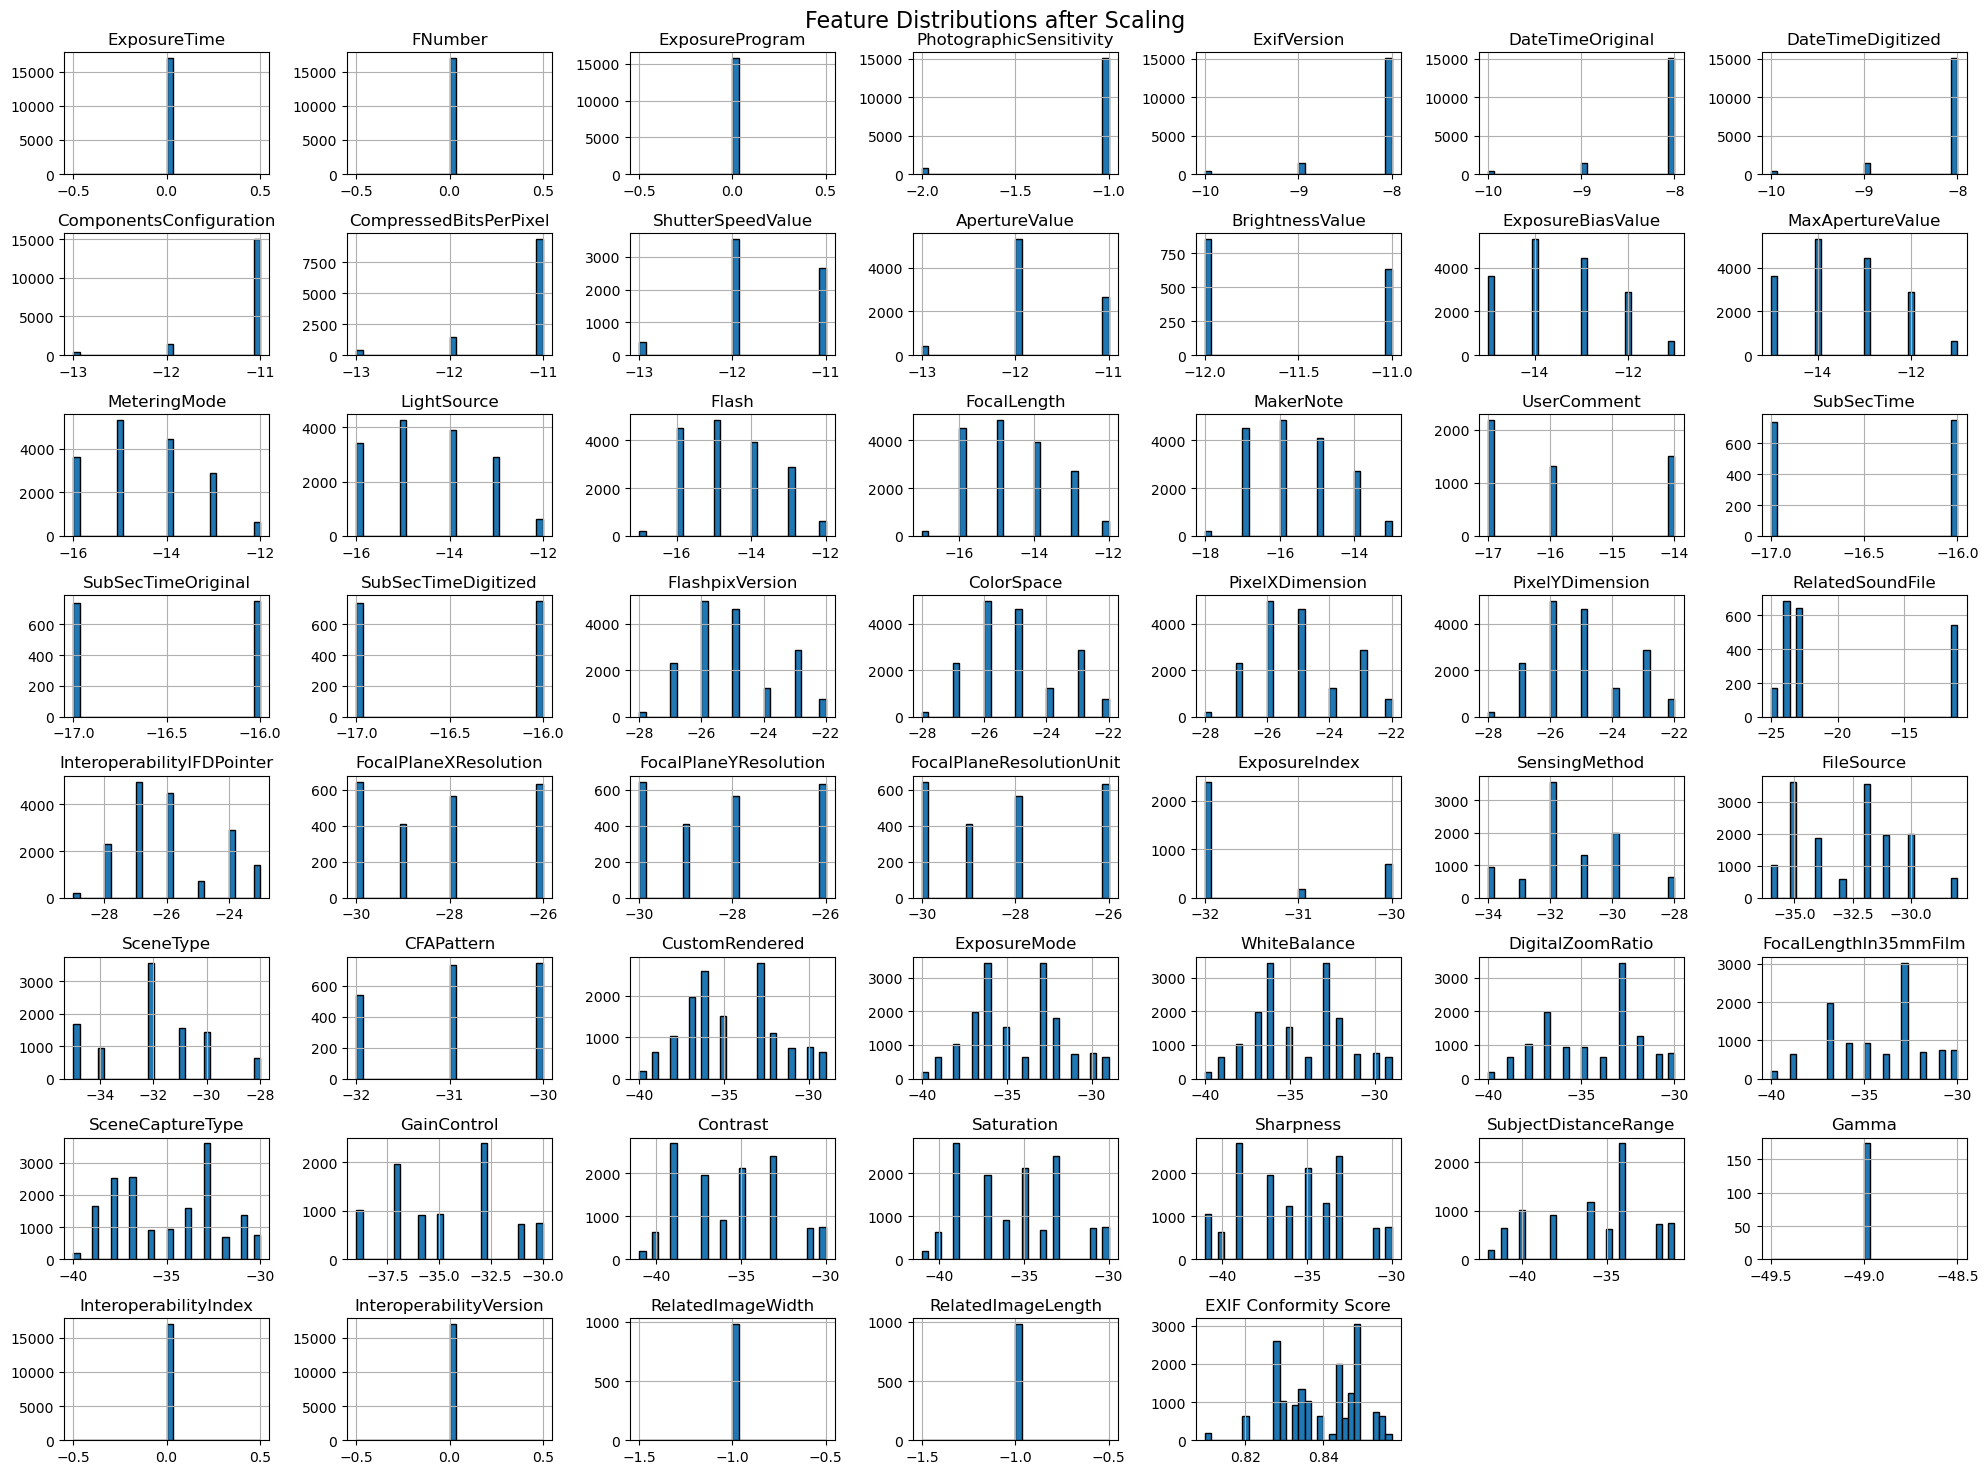

In [199]:
non_nan_df = visuals_df.dropna(axis=1, how='all')
print(len(non_nan_df.columns))

non_nan_df.hist(bins=30, figsize=(20, 15), edgecolor='black')
plt.suptitle('Feature Distributions after Scaling', fontsize=16)
plt.tight_layout()
plt.show()

In [200]:
# Counting non-nan values to show
nan_counts = visuals_df.isna().sum().sum()
non_nan_counts = visuals_df.notna().sum().sum()


print(f"NaN values: {nan_counts}")
print(f"Non-NaN values: {non_nan_counts}")
print(f"Non-NaN percent: {round(non_nan_counts/(non_nan_counts+nan_counts) * 100, 5)}%")



NaN values: 1535718
Non-NaN values: 635290
Non-NaN percent: 29.26244%


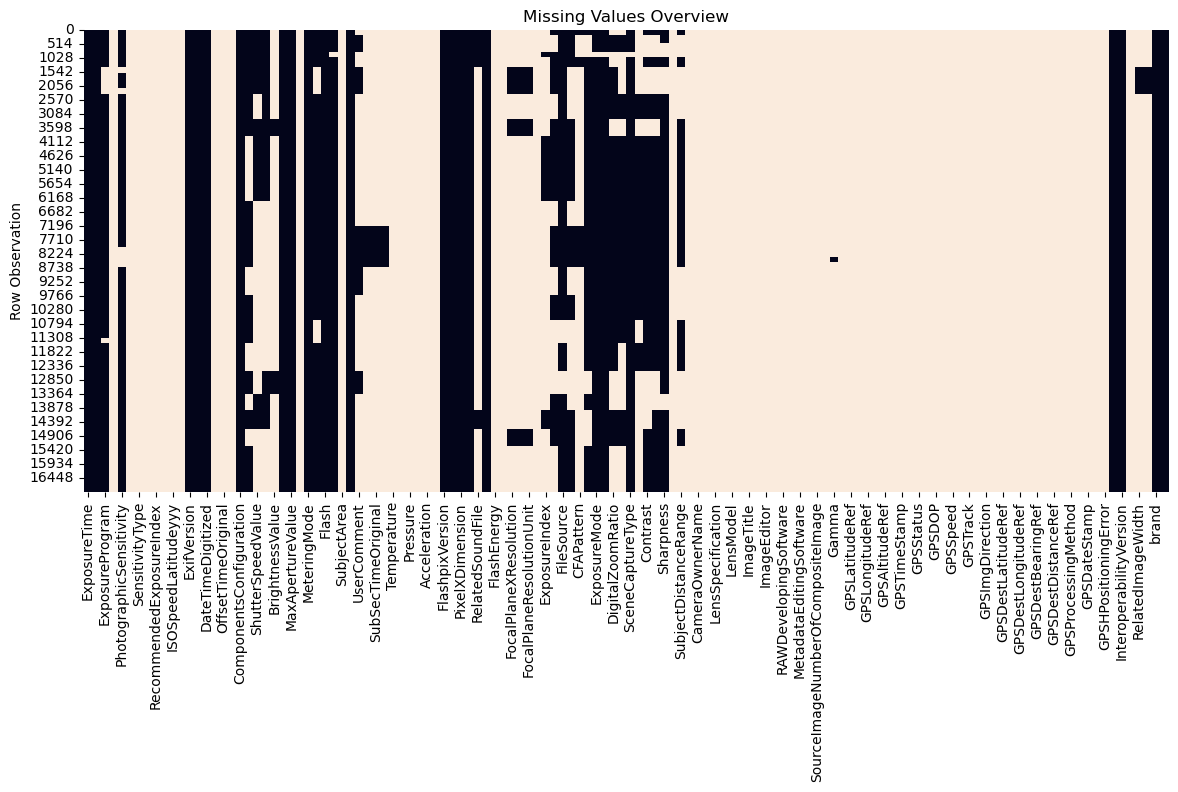

In [201]:

plt.figure(figsize=(14, 6))
sns.heatmap(visuals_df.isna(), cbar=False)
plt.title('Missing Values Overview')
plt.ylabel("Row Observation")
# plt.yticks(ticks=range(len(models)), labels=models, fontsize=6)
plt.yticks()

plt.show()



In [202]:
# 1. Features present in ALL images (no NaNs at all)
features_in_all_images = visuals_df.columns[visuals_df.notnull().all()].tolist()

# 2. Features present in AT LEAST ONE image (not entirely NaN)
features_not_all_nan = visuals_df.columns[visuals_df.notnull().any()].tolist()

print("Features in ALL images:")
print(features_in_all_images)
print(f"\nTotal: {len(features_in_all_images)}")


print("\nFeatures present in AT LEAST ONE image:")
print(features_not_all_nan)
print(f"\nTotal: {len(features_not_all_nan)}")


Features in ALL images:
['ExposureTime', 'FNumber', 'ExifVersion', 'DateTimeOriginal', 'DateTimeDigitized', 'ComponentsConfiguration', 'ExposureBiasValue', 'MaxApertureValue', 'MeteringMode', 'Flash', 'MakerNote', 'FlashpixVersion', 'ColorSpace', 'PixelXDimension', 'PixelYDimension', 'InteroperabilityIFDPointer', 'InteroperabilityIndex', 'InteroperabilityVersion', 'brand', 'EXIF Conformity Score']

Total: 20

Features present in AT LEAST ONE image:
['ExposureTime', 'FNumber', 'ExposureProgram', 'PhotographicSensitivity', 'ExifVersion', 'DateTimeOriginal', 'DateTimeDigitized', 'ComponentsConfiguration', 'CompressedBitsPerPixel', 'ShutterSpeedValue', 'ApertureValue', 'BrightnessValue', 'ExposureBiasValue', 'MaxApertureValue', 'MeteringMode', 'LightSource', 'Flash', 'FocalLength', 'MakerNote', 'UserComment', 'SubSecTime', 'SubSecTimeOriginal', 'SubSecTimeDigitized', 'FlashpixVersion', 'ColorSpace', 'PixelXDimension', 'PixelYDimension', 'RelatedSoundFile', 'InteroperabilityIFDPointer', 'Fo

# Training on Features Only

## Final Processing Before Split (Experimentation)

In [203]:
# FEATURE SUMMARY

print(f"Original number of features: {visuals_df.shape[1]}")

nan_counts = visuals_df.isna().sum()
zero_var = visuals_df.nunique()[visuals_df.nunique() <= 1]

print(f"Total NaN-only features: {(nan_counts == len(visuals_df)).sum()}")
print(f"Total zero-variance features: {len(zero_var)}")

print("\nFeatures with zero variance:")
print(zero_var.index.tolist())


Original number of features: 128
Total NaN-only features: 73
Total zero-variance features: 81

Features with zero variance:
['ExposureTime', 'FNumber', 'ExposureProgram', 'SpectralSensitivity', 'OECF', 'SensitivityType', 'StandardOutputSensitivity', 'RecommendedExposureIndex', 'ISOSpeed', 'ISOSpeedLatitudeyyy', 'ISOSpeedLatitudezzz', 'OffsetTime', 'OffsetTimeOriginal', 'OffsetTimeDigitized', 'SubjectDistance', 'SubjectArea', 'Temperature', 'Humidity', 'Pressure', 'WaterDepth', 'Acceleration', 'CameraElevationAngle', 'FlashEnergy', 'SpatialFrequencyResponse', 'SubjectLocation', 'DeviceSettingDescription', 'ImageUniqueID', 'CameraOwnerName', 'BodySerialNumber', 'LensSpecification', 'LensMake', 'LensModel', 'LensSerialNumber', 'ImageTitle', 'Photographer', 'ImageEditor', 'CameraFirmware', 'RAWDevelopingSoftware', 'ImageEditingSoftware', 'MetadataEditingSoftware', 'CompositeImage', 'SourceImageNumberOfCompositeImage', 'SourceExposureTimesOfCompositeImage', 'Gamma', 'GPSVersionID', 'GPSLati

In [204]:
# VARIANCE FILTERING
# NOTE that visuals_df is a visualization_df. Use training_features when actaully cleaning.

# 1. Drop all-NaN
X_cleaned = training_features.dropna(axis=1, how='all')

# 2. Drop zero-variance
nunique = X_cleaned.nunique()
X_cleaned = X_cleaned.loc[:, nunique > 1]

# 3. Drop near-zero variance
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.0001)
X_reduced = selector.fit_transform(X_cleaned)
kept_cols = X_cleaned.columns[selector.get_support()]

# Create new DataFrame
X_reduced_df = pd.DataFrame(X_reduced, columns=kept_cols)
print(f"Reduced from {visuals_df.shape[1]} ➝ {X_reduced_df.shape[1]} features.")

print("ECS feature present in training features: ","EXIF Conformity Score" in training_features.columns)
print("ECS feature removed during filtering:", "EXIF Conformity Score" in X_reduced_df.columns)


Reduced from 128 ➝ 49 features.
ECS feature present in training features:  True
ECS feature removed during filtering: False


In [205]:
X_reduced_df.head()

,ExposureProgram,PhotographicSensitivity,ExifVersion,DateTimeOriginal,DateTimeDigitized,ComponentsConfiguration,CompressedBitsPerPixel,ShutterSpeedValue,ApertureValue,BrightnessValue,...,FocalLengthIn35mmFilm,SceneCaptureType,GainControl,Contrast,Saturation,Sharpness,SubjectDistanceRange,Gamma,RelatedImageWidth,RelatedImageLength
0,0.272325,0.269632,0.334961,0.334961,0.334961,0.334961,0.710395,1.249191,1.009591,-0.309652,...,-1.275753,0.11221,-1.028522,0.607527,0.54499,0.376527,1.000893,-0.101809,-0.2475,-0.2475
1,0.272325,0.269632,0.334961,0.334961,0.334961,0.334961,0.710395,1.249191,1.009591,-0.309652,...,-1.275753,0.11221,-1.028522,0.607527,0.54499,0.376527,1.000893,-0.101809,-0.2475,-0.2475
2,0.272325,0.269632,0.334961,0.334961,0.334961,0.334961,0.710395,1.249191,1.009591,-0.309652,...,-1.275753,0.11221,-1.028522,0.607527,0.54499,0.376527,1.000893,-0.101809,-0.2475,-0.2475
3,0.272325,0.269632,0.334961,0.334961,0.334961,0.334961,0.710395,1.249191,1.009591,-0.309652,...,-1.275753,0.11221,-1.028522,0.607527,0.54499,0.376527,1.000893,-0.101809,-0.2475,-0.2475
4,0.272325,0.269632,0.334961,0.334961,0.334961,0.334961,0.710395,1.249191,1.009591,-0.309652,...,-1.275753,0.11221,-1.028522,0.607527,0.54499,0.376527,1.000893,-0.101809,-0.2475,-0.2475


## Train-Test Split

In [206]:
# Drop label columns from X
# X = X_reduced_df.drop(columns=["EXIF Conformity Score"])

# Use model-level device attribution as the target
y_brand = test_labels["brand"]
y_model = test_labels["model"]

# Split the dataset for training/testing
X_train_model, X_test_model, y_train_model, y_test_model = train_test_split(
    X_reduced_df, y_model, test_size=0.2, random_state=42, stratify=y_model
)
X_train_brand, X_test_brand, y_train_brand, y_test_brand = train_test_split(
    X_reduced_df, y_brand, test_size=0.2, random_state=42, stratify=y_brand
)

print("Train shape:", X_train_model.shape)
print("Test shape:", X_test_model.shape)
y_model


Train shape: (13568, 49)
Test shape: (3393, 49)


0          Agfa_DC-504
1          Agfa_DC-504
2          Agfa_DC-504
3          Agfa_DC-504
4          Agfa_DC-504
             ...      
16956    Sony_DSC-W170
16957    Sony_DSC-W170
16958    Sony_DSC-W170
16959    Sony_DSC-W170
16960    Sony_DSC-W170
Name: model, Length: 16961, dtype: object

### Random Forest Decision Tree      

#### Brand Attribution (Indicates misclassification is limited to brand)

In [207]:
tree_model_alt = DecisionTreeClassifier(random_state=42)
tree_model_alt.fit(X_train_brand, y_train_brand)

# Predict
y_pred_tree = tree_model_alt.predict(X_test_brand)

# Metrics
print("Decision Tree Results:")
print(classification_report(y_test_brand, y_pred_tree))
print(f"Accuracy: {accuracy_score(y_test_brand, y_pred_tree):.4f}")


Decision Tree Results:
              precision    recall  f1-score   support

        Agfa       1.00      1.00      1.00       272
       Canon       1.00      1.00      1.00       196
       Casio       1.00      1.00      1.00       185
    FujiFilm       1.00      1.00      1.00       126
       Kodak       1.00      1.00      1.00       478
       Nikon       1.00      1.00      1.00       483
     Olympus       1.00      1.00      1.00       208
   Panasonic       1.00      1.00      1.00       186
      Pentax       1.00      1.00      1.00       166
    Praktica       1.00      1.00      1.00       204
       Ricoh       1.00      1.00      1.00       171
      Rollei       1.00      1.00      1.00       118
     Samsung       1.00      1.00      1.00       266
        Sony       1.00      1.00      1.00       334

    accuracy                           1.00      3393
   macro avg       1.00      1.00      1.00      3393
weighted avg       1.00      1.00      1.00      3393

Ac

#### Device Attribution

#### Simple Decision Tree

In [208]:

tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_model, y_train_model)

# Predict
y_pred_tree = tree_model.predict(X_test_model)

# Metrics
print("Decision Tree Results:")
print(classification_report(y_test_model, y_pred_tree))
print(f"Accuracy: {accuracy_score(y_test_model, y_pred_tree):.4f}")
print(f"Precision: {precision_score(y_test_model, y_pred_tree, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test_model, y_pred_tree, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test_model, y_pred_tree, average='weighted'):.4f}")


Decision Tree Results:
                     precision    recall  f1-score   support

        Agfa_DC-504       0.00      0.00      0.00        34
       Agfa_DC-733s       0.88      1.00      0.93        56
       Agfa_DC-830i       1.00      0.89      0.94        73
   Agfa_Sensor505-x       1.00      1.00      1.00        34
    Agfa_Sensor530s       0.69      1.00      0.81        74
       Canon_Ixus55       0.54      1.00      0.70        45
       Canon_Ixus70       1.00      1.00      1.00       113
Canon_PowerShotA640       0.00      0.00      0.00        38
      Casio_EX-Z150       1.00      1.00      1.00       185
FujiFilm_FinePixJ50       1.00      1.00      1.00       126
        Kodak_M1063       1.00      1.00      1.00       478
  Nikon_CoolPixS710       1.00      1.00      1.00       185
         Nikon_D200       1.00      1.00      1.00       151
          Nikon_D70       1.00      1.00      1.00       147
 Olympus_mju_1050SW       1.00      1.00      1.00       208


c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.8839
Recall:    0.9207
F1 Score:  0.8959


c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Exhaustive Random Forest

In [209]:

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Set up and run grid search
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='accuracy', verbose=2)
grid_search.fit(X_train_model, y_train_model)

# Use best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_model)

# Print best params and scores
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)
print("\nEvaluation on Test Set:")
print(classification_report(y_test_model, y_pred_best))
print(f"Accuracy:  {accuracy_score(y_test_model, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test_model, y_pred_best, average='weighted', zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test_model, y_pred_best, average='weighted', zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test_model, y_pred_best, average='weighted', zero_division=0):.4f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.9208431197696834

Evaluation on Test Set:
                     precision    recall  f1-score   support

        Agfa_DC-504       0.00      0.00      0.00        34
       Agfa_DC-733s       0.88      1.00      0.93        56
       Agfa_DC-830i       1.00      0.89      0.94        73
   Agfa_Sensor505-x       1.00      1.00      1.00        34
    Agfa_Sensor530s       0.69      1.00      0.81        74
       Canon_Ixus55       0.00      0.00      0.00        45
       Canon_Ixus70       1.00      1.00      1.00       113
Canon_PowerShotA640       0.46      1.00      0.63        38
      Casio_EX-Z150       1.00      1.00      1.00       185
FujiFilm_FinePixJ50       1.00      1.00      1.00       126
        Kodak_M1063       1.00      1.00      1.00       478
  Nik

c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.8818
Recall:    0.9187
F1 Score:  0.8936


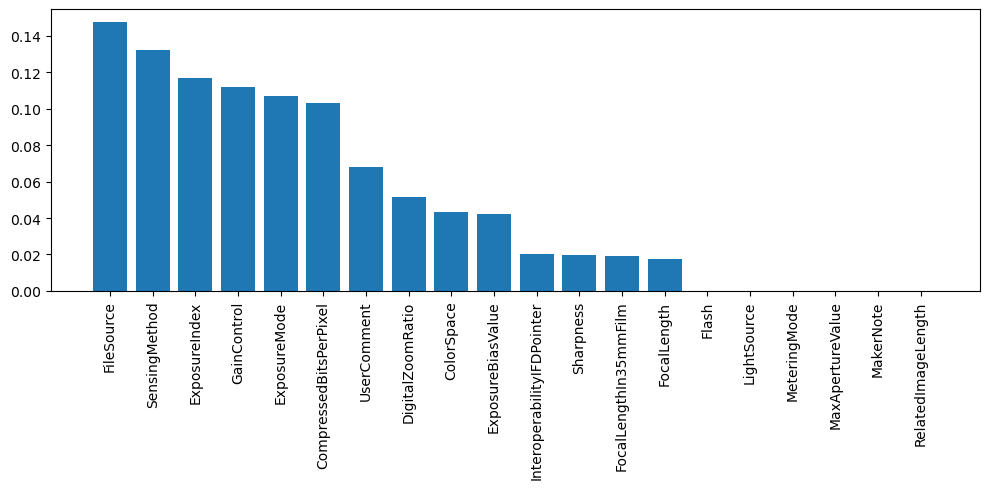

In [210]:
importances = tree_model.feature_importances_

# Sort
indices = importances.argsort()[::-1]

feature_names = X_train_model.columns

# Plot
plt.figure(figsize=(10,5))
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()

### K-Nearest Neighbour

In [211]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_model, y_train_model)
X_test_selected = selector.transform(X_test_model)

In [212]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_selected, y_train_model)
y_pred = knn.predict(X_test_selected)

print(classification_report(y_test_model, y_pred_best))
print(f"Accuracy:  {accuracy_score(y_test_model, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test_model, y_pred_best, average='weighted', zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test_model, y_pred_best, average='weighted', zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test_model, y_pred_best, average='weighted', zero_division=0):.4f}")


c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                     precision    recall  f1-score   support

        Agfa_DC-504       0.00      0.00      0.00        34
       Agfa_DC-733s       0.88      1.00      0.93        56
       Agfa_DC-830i       1.00      0.89      0.94        73
   Agfa_Sensor505-x       1.00      1.00      1.00        34
    Agfa_Sensor530s       0.69      1.00      0.81        74
       Canon_Ixus55       0.00      0.00      0.00        45
       Canon_Ixus70       1.00      1.00      1.00       113
Canon_PowerShotA640       0.46      1.00      0.63        38
      Casio_EX-Z150       1.00      1.00      1.00       185
FujiFilm_FinePixJ50       1.00      1.00      1.00       126
        Kodak_M1063       1.00      1.00      1.00       478
  Nikon_CoolPixS710       1.00      1.00      1.00       185
         Nikon_D200       1.00      1.00      1.00       151
          Nikon_D70       1.00      1.00      1.00       147
 Olympus_mju_1050SW       1.00      1.00      1.00       208
 Panasonic_DMC-FZ50    


KNN Classification Report:
                     precision    recall  f1-score   support

        Agfa_DC-504       0.00      0.00      0.00        34
       Agfa_DC-733s       0.88      1.00      0.93        56
       Agfa_DC-830i       1.00      0.89      0.94        73
   Agfa_Sensor505-x       1.00      1.00      1.00        34
    Agfa_Sensor530s       0.69      1.00      0.81        74
       Canon_Ixus55       0.00      0.00      0.00        45
       Canon_Ixus70       1.00      1.00      1.00       113
Canon_PowerShotA640       0.46      1.00      0.63        38
      Casio_EX-Z150       1.00      1.00      1.00       185
FujiFilm_FinePixJ50       1.00      1.00      1.00       126
        Kodak_M1063       1.00      1.00      1.00       478
  Nikon_CoolPixS710       1.00      1.00      1.00       185
         Nikon_D200       1.00      1.00      1.00       151
          Nikon_D70       1.00      1.00      1.00       147
 Olympus_mju_1050SW       1.00      1.00      1.00      

<function matplotlib.pyplot.grid(visible: 'bool | None' = None, which: "Literal['major', 'minor', 'both']" = 'major', axis: "Literal['both', 'x', 'y']" = 'both', **kwargs) -> 'None'>

c:\Users\saete\anaconda3\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  func(*args, **kwargs)
c:\Users\saete\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


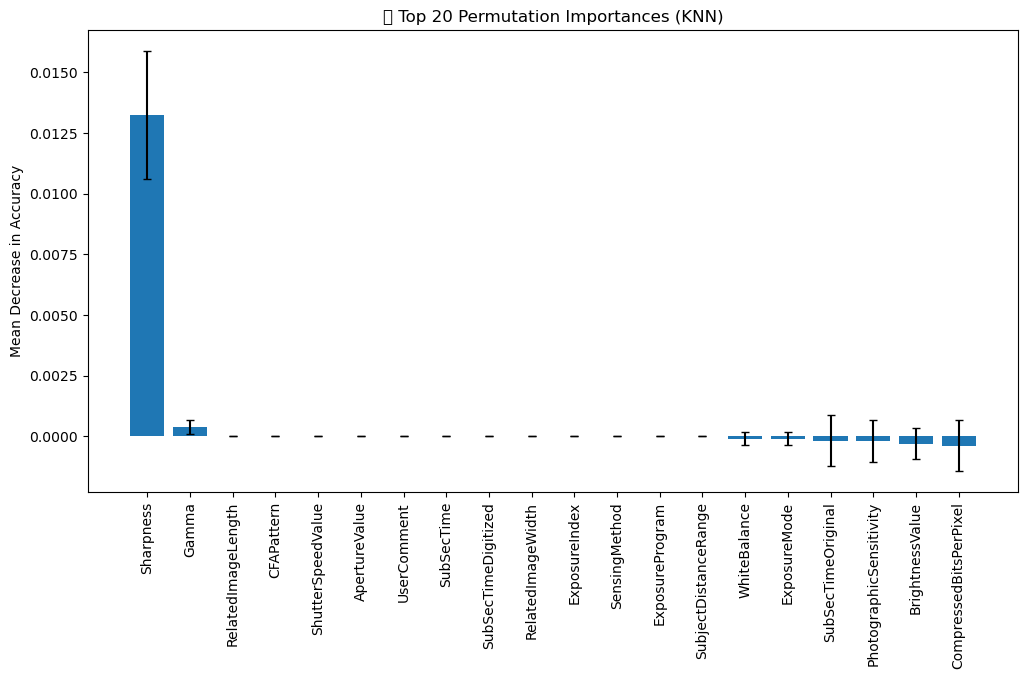

In [213]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_model, y_train_model)

# Predict on the test set
y_pred_knn = knn_model.predict(X_test_model)

# Print classification report
print("\nKNN Classification Report:")
print(classification_report(y_test_model, y_pred_knn, zero_division=0))

# Print core metrics
acc = accuracy_score(y_test_model, y_pred_knn)
prec = precision_score(y_test_model, y_pred_knn, average='weighted', zero_division=0)
rec = recall_score(y_test_model, y_pred_knn, average='weighted', zero_division=0)
f1 = f1_score(y_test_model, y_pred_knn, average='weighted', zero_division=0)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Calculate permutation importance
print("Calculating Permutation Importances (KNN)...")
perm_result = permutation_importance(
    knn_model,
    X_test_model,
    y_test_model,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Get top 20 features
top_idx = np.argsort(perm_result.importances_mean)[::-1][:20]
top_features = [X_train_model.columns[i] for i in top_idx]

# Plot the importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_idx)), perm_result.importances_mean[top_idx],
        yerr=perm_result.importances_std[top_idx], capsize=3)
plt.xticks(range(len(top_idx)), top_features, rotation=90)
plt.ylabel("Mean Decrease in Accuracy")
plt.title("🔍 Top 20 Permutation Importances (KNN)")
plt.grid


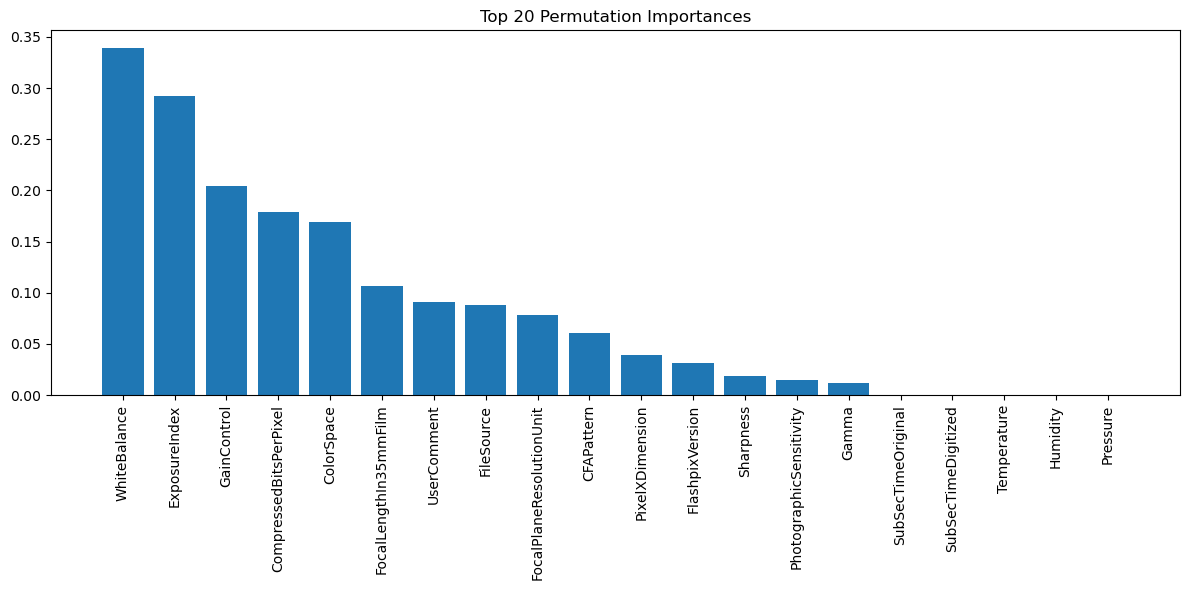

In [214]:
from sklearn.inspection import permutation_importance

# Split your real data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Fit model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Run permutation importance
result = permutation_importance(clf, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

# Visualize top 20 features
importances = result.importances_mean
sorted_idx = importances.argsort()[::-1][:20]
plt.figure(figsize=(12, 6))
plt.bar(range(20), importances[sorted_idx])
plt.xticks(range(20), X.columns[sorted_idx], rotation=90)
plt.title("Top 20 Permutation Importances")
plt.tight_layout()
plt.show()

#### Dimensionality Reduction

In [215]:
important_features_tree = [feature_names[i] for i in indices[:15]]

In [216]:
important_features_tree 

['FileSource',
 'SensingMethod',
 'ExposureIndex',
 'GainControl',
 'ExposureMode',
 'CompressedBitsPerPixel',
 'UserComment',
 'DigitalZoomRatio',
 'ColorSpace',
 'ExposureBiasValue',
 'InteroperabilityIFDPointer',
 'Sharpness',
 'FocalLengthIn35mmFilm',
 'FocalLength',
 'Flash']

In [217]:
X_train_model[important_features_tree]

,FileSource,SensingMethod,ExposureIndex,GainControl,ExposureMode,CompressedBitsPerPixel,UserComment,DigitalZoomRatio,ColorSpace,ExposureBiasValue,InteroperabilityIFDPointer,Sharpness,FocalLengthIn35mmFilm,FocalLength,Flash
11016,-3.011878,-1.069946,-0.486863,-1.028522,0.053976,0.710395,-0.647006,0.586361,-1.347364,-0.450903,-1.310620,0.360701,0.773851,0.087222,-1.179374
6243,0.334446,0.933386,2.052714,0.975795,0.116040,-1.408541,-0.647006,0.600494,0.038695,0.446090,-0.021135,0.382857,0.786661,0.107500,0.510242
7741,0.341367,0.937529,-0.486863,0.982020,0.147072,0.710395,1.545216,0.607560,2.117782,-0.450903,1.913092,0.392352,0.793066,0.097361,-0.334566
12439,0.320604,-1.069946,-0.486863,0.963346,0.064320,-1.408541,-0.647006,0.588716,-1.347364,-1.347896,-1.310620,0.363866,-1.275753,0.087222,-1.179374
13783,0.330986,0.931314,-0.486863,-1.028522,0.095352,-1.408541,-0.647006,-1.674932,0.038695,0.446090,-0.021135,-2.674649,-1.275753,0.107500,0.510242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,0.337907,-1.069946,-0.486863,-1.028522,0.116040,0.710395,1.549676,0.600494,1.424753,1.343083,1.913092,0.373362,0.786661,0.117638,1.355049
13460,0.330986,0.931314,-0.486863,-1.028522,0.095352,-1.408541,-0.647006,-1.674932,0.038695,0.446090,-0.021135,-2.674649,-1.275753,0.107500,0.510242
15021,0.334446,0.933386,-0.486863,-1.028522,0.105696,-1.408541,-0.647006,0.598138,-1.347364,-1.347896,-1.310620,0.376527,0.784526,0.087222,-1.179374
8748,0.324065,-1.069946,-0.486863,0.967496,0.074664,-1.408541,1.542986,0.591072,-0.654335,-1.347896,-0.665878,0.370197,0.778121,0.087222,-1.179374


#### Decision Tree and KNN with Reduced Feature Space

In [218]:

tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_model[important_features_tree], y_train_model)

# Predict
y_pred_tree = tree_model.predict(X_test_model[important_features_tree])

# Metrics
print("Decision Tree Results:")
print(classification_report(y_test_model, y_pred_tree))
print(f"Accuracy: {accuracy_score(y_test_model, y_pred_tree):.4f}")


Decision Tree Results:


c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                     precision    recall  f1-score   support

        Agfa_DC-504       0.00      0.00      0.00        34
       Agfa_DC-733s       0.88      1.00      0.93        56
       Agfa_DC-830i       1.00      0.89      0.94        73
   Agfa_Sensor505-x       1.00      1.00      1.00        34
    Agfa_Sensor530s       0.69      1.00      0.81        74
       Canon_Ixus55       0.54      1.00      0.70        45
       Canon_Ixus70       1.00      1.00      1.00       113
Canon_PowerShotA640       0.00      0.00      0.00        38
      Casio_EX-Z150       1.00      1.00      1.00       185
FujiFilm_FinePixJ50       1.00      1.00      1.00       126
        Kodak_M1063       1.00      1.00      1.00       478
  Nikon_CoolPixS710       1.00      1.00      1.00       185
         Nikon_D200       1.00      1.00      1.00       151
          Nikon_D70       1.00      1.00      1.00       147
 Olympus_mju_1050SW       1.00      1.00      1.00       208
 Panasonic_DMC-FZ50    

c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [219]:
knn_model = KNeighborsClassifier(n_neighbors=5)  # 5 neighbors, you can tweak this later
knn_model.fit(X_train_model[important_features_tree], y_train_model)

# Predict
y_pred_knn = knn_model.predict(X_test_model[important_features_tree])

# Metrics
print("\nKNN Results:")
print(classification_report(y_test_model, y_pred_knn))
print(f"Accuracy: {accuracy_score(y_test_model, y_pred_knn):.4f}")





KNN Results:


c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                     precision    recall  f1-score   support

        Agfa_DC-504       0.00      0.00      0.00        34
       Agfa_DC-733s       0.88      1.00      0.93        56
       Agfa_DC-830i       1.00      0.89      0.94        73
   Agfa_Sensor505-x       1.00      1.00      1.00        34
    Agfa_Sensor530s       0.69      1.00      0.81        74
       Canon_Ixus55       0.00      0.00      0.00        45
       Canon_Ixus70       1.00      1.00      1.00       113
Canon_PowerShotA640       0.46      1.00      0.63        38
      Casio_EX-Z150       1.00      1.00      1.00       185
FujiFilm_FinePixJ50       1.00      1.00      1.00       126
        Kodak_M1063       1.00      1.00      1.00       478
  Nikon_CoolPixS710       1.00      1.00      1.00       185
         Nikon_D200       1.00      1.00      1.00       151
          Nikon_D70       1.00      1.00      1.00       147
 Olympus_mju_1050SW       1.00      1.00      1.00       208
 Panasonic_DMC-FZ50    

c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### PCA dimenionality reduction

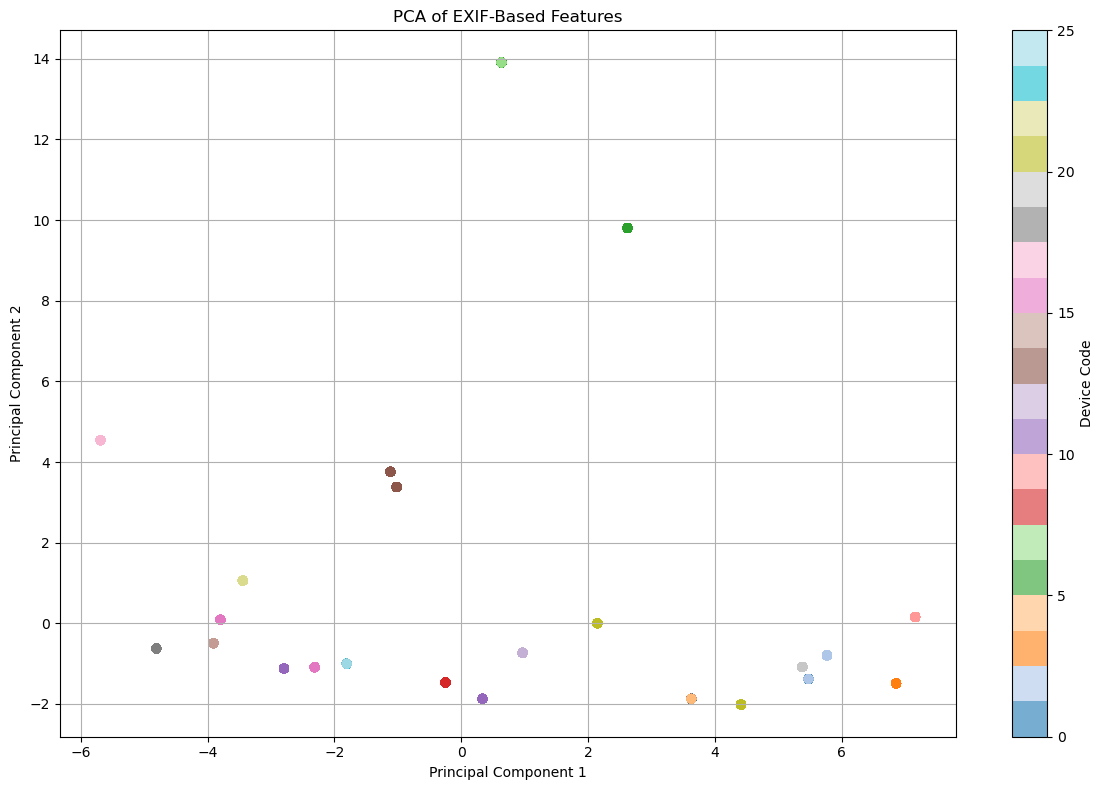

Explained Variance Ratio (PCA components): [0.23423752 0.20466565]


In [220]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Ensure y is a pandas Series (e.g., model_device labels)
y_series = pd.Series(y_model).astype("category")
y_codes = y_series.cat.codes

# Run PCA on the full feature set
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_codes, cmap='tab20', alpha=0.6)
plt.title("PCA of EXIF-Based Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.colorbar(scatter, label="Device Code")
plt.tight_layout()
plt.show()

# Explained variance
print("Explained Variance Ratio (PCA components):", pca.explained_variance_ratio_)


# Training ECS Metric Only

### Train-Test Split

In [221]:
X_ecs = training_features[["EXIF Conformity Score"]]
y_ecs = test_labels["model"]

# Train/test split
X_train_ecs, X_test_ecs, y_train_ecs, y_test_ecs = train_test_split(
    X_ecs, y_ecs, test_size=0.2, random_state=42, stratify=y_ecs
)

### Decision Tree

In [222]:

# Train a simple decision tree
clf_ecs = DecisionTreeClassifier(random_state=42)
clf_ecs.fit(X_train_ecs, y_train_ecs)

# Predict and evaluate
y_pred_ecs = clf_ecs.predict(X_test_ecs)

print("ECS-only Model Performance")
print(classification_report(y_test_ecs, y_pred_ecs))
print(f"Accuracy: {accuracy_score(y_test_ecs, y_pred_ecs):.4f}")


ECS-only Model Performance


c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                     precision    recall  f1-score   support

        Agfa_DC-504       0.00      0.00      0.00        34
       Agfa_DC-733s       0.88      1.00      0.93        56
       Agfa_DC-830i       1.00      0.89      0.94        73
   Agfa_Sensor505-x       1.00      1.00      1.00        34
    Agfa_Sensor530s       0.69      1.00      0.81        74
       Canon_Ixus55       0.54      1.00      0.70        45
       Canon_Ixus70       1.00      1.00      1.00       113
Canon_PowerShotA640       0.00      0.00      0.00        38
      Casio_EX-Z150       1.00      1.00      1.00       185
FujiFilm_FinePixJ50       1.00      1.00      1.00       126
        Kodak_M1063       1.00      1.00      1.00       478
  Nikon_CoolPixS710       1.00      1.00      1.00       185
         Nikon_D200       1.00      1.00      1.00       151
          Nikon_D70       1.00      1.00      1.00       147
 Olympus_mju_1050SW       1.00      1.00      1.00       208
 Panasonic_DMC-FZ50    

c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [223]:
knn_model = KNeighborsClassifier(n_neighbors=5)  # 5 neighbors, you can tweak this later
knn_model.fit(X_train_ecs, y_train_ecs)

# Predict
y_pred_knn = knn_model.predict(X_test_ecs)

# Metrics
print("\nKNN Results:")
print(classification_report(y_test_ecs, y_pred_knn))
print(f"Accuracy: {accuracy_score(y_test_ecs, y_pred_knn):.4f}")





KNN Results:


c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                     precision    recall  f1-score   support

        Agfa_DC-504       0.00      0.00      0.00        34
       Agfa_DC-733s       0.88      1.00      0.93        56
       Agfa_DC-830i       1.00      0.89      0.94        73
   Agfa_Sensor505-x       1.00      1.00      1.00        34
    Agfa_Sensor530s       0.69      1.00      0.81        74
       Canon_Ixus55       0.54      1.00      0.70        45
       Canon_Ixus70       1.00      1.00      1.00       113
Canon_PowerShotA640       0.00      0.00      0.00        38
      Casio_EX-Z150       1.00      1.00      1.00       185
FujiFilm_FinePixJ50       1.00      1.00      1.00       126
        Kodak_M1063       1.00      1.00      1.00       478
  Nikon_CoolPixS710       1.00      1.00      1.00       185
         Nikon_D200       1.00      1.00      1.00       151
          Nikon_D70       1.00      1.00      1.00       147
 Olympus_mju_1050SW       1.00      1.00      1.00       208
 Panasonic_DMC-FZ50    

c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Training on Both Features

In [224]:
X_full = training_features
y_full = offset_scaled["model"]

# Split
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

In [225]:
clf_full = DecisionTreeClassifier(random_state=42)
clf_full.fit(X_train_full, y_train_full)


y_pred_full = clf_full.predict(X_test_full)

print("Full Feature Model Performance")
print(classification_report(y_test_full, y_pred_full))
print(f"Accuracy: {accuracy_score(y_test_full, y_pred_full):.4f}")


Full Feature Model Performance


c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                     precision    recall  f1-score   support

        Agfa_DC-504       0.00      0.00      0.00        34
       Agfa_DC-733s       0.88      1.00      0.93        56
       Agfa_DC-830i       1.00      0.89      0.94        73
   Agfa_Sensor505-x       1.00      1.00      1.00        34
    Agfa_Sensor530s       0.69      1.00      0.81        74
       Canon_Ixus55       0.54      1.00      0.70        45
       Canon_Ixus70       1.00      1.00      1.00       113
Canon_PowerShotA640       0.00      0.00      0.00        38
      Casio_EX-Z150       1.00      1.00      1.00       185
FujiFilm_FinePixJ50       1.00      1.00      1.00       126
        Kodak_M1063       1.00      1.00      1.00       478
  Nikon_CoolPixS710       1.00      1.00      1.00       185
         Nikon_D200       1.00      1.00      1.00       151
          Nikon_D70       1.00      1.00      1.00       147
 Olympus_mju_1050SW       1.00      1.00      1.00       208
 Panasonic_DMC-FZ50    

c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


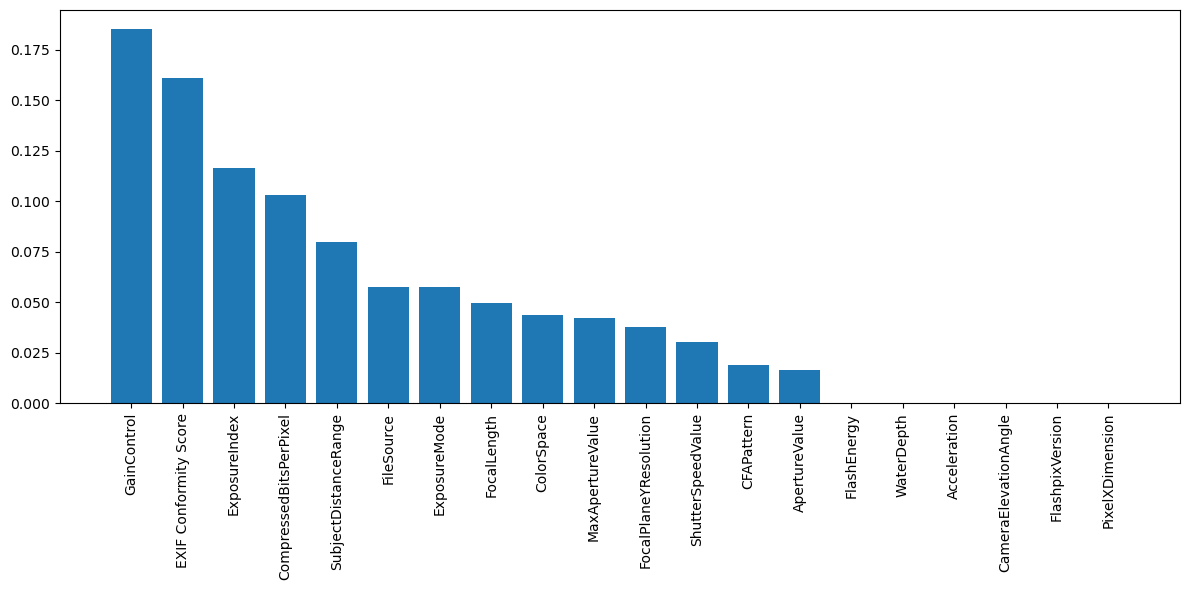

In [226]:
importances = clf_full.feature_importances_

# Sort
indices = importances.argsort()[::-1]
feature_names = X_train_full.columns

# Plot
plt.figure(figsize=(12,6))
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()

# Training with Cross Validation

#### Due to sample scarcity / unlucky splits


In [227]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Reuse your test_labels (model_device)
y = test_labels["model"]

# Models and feature sets
feature_sets = {
    "Offsets Only": X,
    "ECS Only": training_features[["EXIF Conformity Score"]],
    "Offsets + ECS": training_features
}

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for model_name, model in models.items():
    print(f"\n=== {model_name} ===")
    for feature_name, X in feature_sets.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        print(f"{feature_name} - Accuracy Mean: {scores.mean():.4f} | Std: {scores.std():.4f}")



=== Decision Tree ===
Offsets Only - Accuracy Mean: 0.9218 | Std: 0.0009
ECS Only - Accuracy Mean: 0.9218 | Std: 0.0009
Offsets + ECS - Accuracy Mean: 0.9218 | Std: 0.0009

=== KNN ===
Offsets Only - Accuracy Mean: 0.9084 | Std: 0.0008
ECS Only - Accuracy Mean: 0.8990 | Std: 0.0007
Offsets + ECS - Accuracy Mean: 0.9084 | Std: 0.0008

=== Random Forest ===
Offsets Only - Accuracy Mean: 0.9218 | Std: 0.0009
ECS Only - Accuracy Mean: 0.9218 | Std: 0.0009
Offsets + ECS - Accuracy Mean: 0.9218 | Std: 0.0009


# Feature Engiene

### Now that we now the most important tags, we'll narrow features down, focusing on binary presence, offsets on present tags, removing features with insignificant variance